# 学校のクラス編成

### ② データの確認

In [50]:
import pandas as pd
s_df = pd.read_csv('students.csv')

In [51]:
len(s_df)

318

In [52]:
s_df.head()

student_id  gender  leader_flag  support_flag  score
0           1       0            0             0    335
1           2       1            0             0    379
2           3       0            0             0    350
3           4       0            0             0    301
4           5       1            0             0    317

In [53]:
s_df['student_id']

0        1
1        2
2        3
3        4
4        5
      ... 
313    314
314    315
315    316
316    317
317    318
Name: student_id, Length: 318, dtype: int64

In [54]:
s_df['student_id'].max()

np.int64(318)

In [55]:
s_df['student_id'].min()

np.int64(1)

In [56]:
set(range(1,319)) == set(s_df['student_id'].tolist())

True

In [57]:
s_df['gender'].value_counts()

gender
0    160
1    158
Name: count, dtype: int64

In [58]:
s_df['score'].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<Axes: >

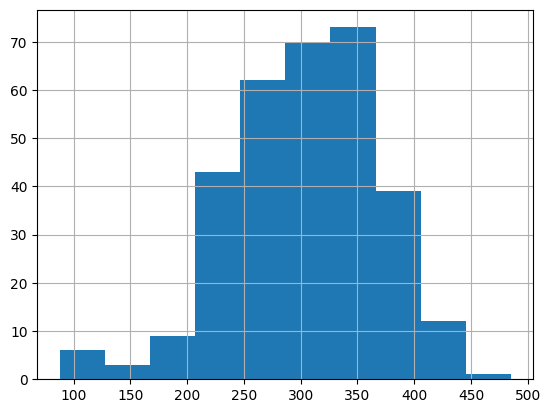

In [59]:
s_df['score'].hist()

In [60]:
s_df['leader_flag'].value_counts()

leader_flag
0    301
1     17
Name: count, dtype: int64

In [61]:
s_df['support_flag'].value_counts()

support_flag
0    314
1      4
Name: count, dtype: int64

In [62]:
s_pair_df = pd.read_csv('student_pairs.csv')
print(len(s_pair_df))

3


In [63]:
s_pair_df.head()

student_id1  student_id2
0          118          189
1           72           50
2          314          233

### ③数理モデリングと実装

In [64]:
import pulp

In [65]:
# 数理モデルのインスタンス作成
prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

In [66]:
# 生徒のリスト
S = s_df['student_id'].tolist()

# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [67]:
# 生徒とクラスのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるかを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

In [68]:
# (1) 各生徒は1つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum(x[s,c] for c in C) == 1

In [69]:
# (2) 各クラスの生徒の人数は39人以上、40人以下
for c in C:
    prob += pulp.lpSum(x[s,c] for s in S) >= 39
    prob += pulp.lpSum(x[s,c] for s in S) <= 40

In [70]:
# 男子生徒のリスト
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

In [71]:
# 学力を辞書表現に変換
score = {row.student_id:row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()

# (4) 各クラスの学力試験の平均点は学年平均点±10点とする
for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s,c] for s in S]) <= pulp.lpSum([x[s,c] * score[s] for s in S])
    prob += pulp.lpSum([x[s,c] * score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

In [72]:
# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

# (5) 各クラスにリーダー気質の生徒を2人以上割り当てる
for c in C:
    prob += pulp.lpSum(x[s,c] for s in S_leader) >= 2

In [73]:
# 特別な支援が必要な生徒の場合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする
for c in C:
    prob += pulp.lpSum(x[s,c] for s in S_support) <= 1

In [74]:
# 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない
for s1, s2, in SS:
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

In [75]:
status = prob.solve()
print(status)
print(pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/isobekosuke/home/operations_research/venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/b9/s3mpk10s0s1bl06d5p5990h80000gn/T/331adbe3fcea4d589895dd93ad51c4ba-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/b9/s3mpk10s0s1bl06d5p5990h80000gn/T/331adbe3fcea4d589895dd93ad51c4ba-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 20981 RHS
At line 21388 BOUNDS
At line 23934 ENDATA
Problem MODEL has 406 rows, 2545 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.11 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cbc0038I Initial state - 38 integers unsatisfied sum - 7.12529
Cbc003

In [76]:
# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value() == 1]

for c, Ss, in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Class: A
Num: 39
Student: [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298]

Class: B
Num: 40
Student: [11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 146, 149, 159, 167, 170, 172, 176, 190, 203, 213, 220, 222, 231, 238, 245, 263, 270, 275, 276, 283, 287, 290, 317]

Class: C
Num: 40
Student: [3, 14, 23, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 201, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 274, 277, 278, 301, 318]

Class: D
Num: 40
Student: [10, 13, 16, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 128, 134, 139, 140, 158, 161, 175, 183, 188, 192, 198, 200, 205, 221, 225, 235, 241, 252, 255, 256, 257, 261, 266, 293, 316]

Class: E
Num: 39
Student: [4, 5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 115, 129, 132, 141, 143, 150, 154, 164, 166, 184, 189, 195, 196, 197

### まとめ

In [77]:
import pandas as pd
import pulp

s_df = pd.read_csv('students.csv')
s_pair_df = pd.read_csv('student_pairs.csv')

prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

# 生徒のリスト
S = s_df['student_id'].tolist()

# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# 生徒とクラスのペアのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるかを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# (1) 各生徒は1つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum(x[s,c] for c in C) == 1

# (2) 各クラスの生徒の人数は39人以上、40人以下
for c in C:
    prob += pulp.lpSum(x[s,c] for s in S) >= 39
    prob += pulp.lpSum(x[s,c] for s in S) <= 40

# 男子生徒のリスト
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする
for c in C:
    prob += pulp.lpSum(x[s,c] for s in S_male) <= 20
    prob += pulp.lpSum(x[s,c] for s in S_female) <= 20

# 学力を辞書表現に変換
score = {row.student_id:row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()

# (4) 各クラスの学力試験の平均点は学年平均点±10点とする
for c in C:
    prob += pulp.lpSum(x[s,c] * score[s] for s in S) >= (score_mean - 10) * pulp.lpSum(x[s,c] for s in S)
    prob += pulp.lpSum(x[s,c] * score[s] for s in S) <= (score_mean + 10) * pulp.lpSum(x[s,c] for s in S)

# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

# (5) 各クラスにリーダー気質の生徒を2人以上割り当てる
for c in C:
    prob += pulp.lpSum(x[s,c] for s in S_leader) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする
for c in C:
    prob += pulp.lpSum(x[s,c] for s in S_support) <= 1

# 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない
for s1, s2 in SS:
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

# 求解
status = prob.solve()
print('Status:', pulp.LpStatus[status])

# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value() == 1]

for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Students:', Ss)
    print()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/isobekosuke/home/operations_research/venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/b9/s3mpk10s0s1bl06d5p5990h80000gn/T/6e62369170a145c98cb97afb66553503-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/b9/s3mpk10s0s1bl06d5p5990h80000gn/T/6e62369170a145c98cb97afb66553503-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 20981 RHS
At line 21388 BOUNDS
At line 23934 ENDATA
Problem MODEL has 406 rows, 2545 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.11 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cbc0038I Initial state - 38 integers unsatisfied sum - 8.90073
Cbc003

## 数理モデルの検証

### 解が要件を満たしているかどうか確認する

In [78]:
# 要件(1) 学年の全生徒をそれぞれ1つのクラスに割り当てる
for s in S:
    # 割り当てられたクラスを取得
    assigned_class = [c for c in C if x[s,c].value() == 1]

    # 1つのクラスに割り当てられているか確認
    if len(assigned_class) != 1:
        print('error:', s, assigned_class)

In [79]:
# 検証用のデータフレームの用意
result_df = s_df.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {s:c for s in S for c in C if x[s,c].value() == 1}

# 生徒データに各生徒がどのクラスに割り当てられたかの情報を結合
result_df['assigned_class'] = result_df['student_id'].map(S2C)
result_df.head()

student_id  gender  leader_flag  support_flag  score assigned_class
0           1       0            0             0    335              F
1           2       1            0             0    379              A
2           3       0            0             0    350              C
3           4       0            0             0    301              B
4           5       1            0             0    317              E

In [80]:
# 要件(2) 各クラスの生徒の人数は39人以上、40人以下
result_df.groupby('assigned_class')['student_id'].count()

assigned_class
A    39
B    40
C    40
D    40
E    40
F    40
G    40
H    39
Name: student_id, dtype: int64

In [81]:
# 要件(3) 各クラスの男子生徒、女子生徒の人数は20人以下とする
result_df.groupby(['assigned_class', 'gender'])['student_id'].count()

assigned_class  gender
A               0         20
                1         19
B               0         20
                1         20
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         20
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

In [82]:
# 要件(4) 各クラスの学力試験の平均点は学年平均点±10点とする
result_df.groupby('assigned_class')['score'].mean()

assigned_class
A    309.000000
B    303.300000
C    312.125000
D    308.600000
E    294.750000
F    294.675000
G    312.200000
H    294.410256
Name: score, dtype: float64

In [83]:
# 要件(5) 各クラスにリーダー気質の生徒を2人以上割り当てる
result_df.groupby(['assigned_class'])['leader_flag'].sum()

assigned_class
A    3
B    2
C    2
D    2
E    2
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [84]:
# 要件(6) 特別な支援が必要な生徒を1人以下とする
result_df.groupby(['assigned_class'])['support_flag'].sum()

assigned_class
A    0
B    1
C    1
D    0
E    1
F    0
G    1
H    0
Name: support_flag, dtype: int64

In [85]:
# 要件(7) 特定ペアの生徒は同一クラスに割り当てない
for i, (s1, s2) in enumerate(SS):
    print('case:', i)
    c1 = S2C[s1]
    c2 = S2C[s2]
    print('s1:{}-{}'.format(s1, c1))
    print('s2:{}-{}'.format(s2, c2))
    print('')

case: 0
s1:118-G
s2:189-E

case: 1
s1:72-E
s2:50-B

case: 2
s1:314-H
s2:233-A



In [86]:
import matplotlib.pyplot as plt

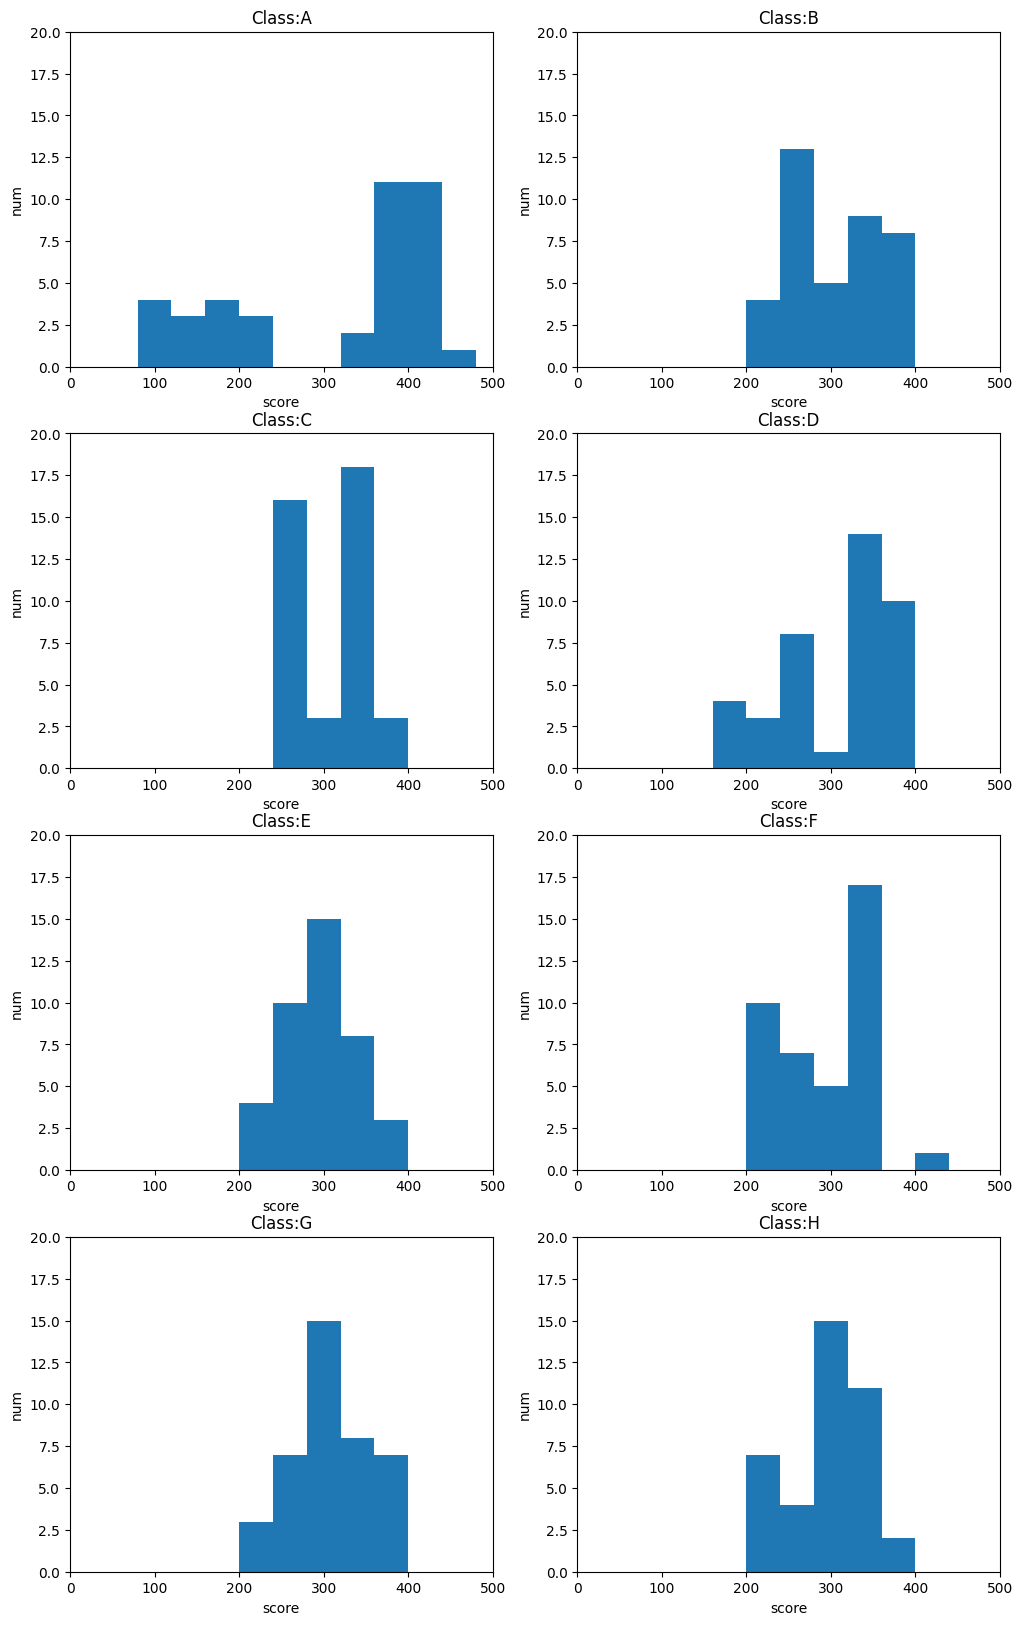

In [87]:
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(C):
    cls_df = result_df[result_df['assigned_class'] == c]
    ax = fig.add_subplot(4, 2, i+1, xlabel='score', ylabel='num', xlim=(0, 500), ylim=(0, 20), title='Class:{:s}'.format(c))
    ax.hist(cls_df['score'], bins=range(0, 500, 40))

### 制約の改善と数理最適化モデルの修正

In [90]:
# 初期クラス編成のデータを作成
# 学力をもとに順位を付与
s_df['score_rank'] = s_df['score'].rank(ascending=False, method='first')

# 学力順にクラス編成し、init_assigned_classカラムを作成
class_dic = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H'}
s_df['init_assigned_class'] = s_df['score_rank'].map(lambda x: x % 8).map(class_dic)
s_df.head()

student_id  gender  leader_flag  support_flag  score  score_rank  \
0           1       0            0             0    335       109.0   
1           2       1            0             0    379        38.0   
2           3       0            0             0    350        79.0   
3           4       0            0             0    301       172.0   
4           5       1            0             0    317       147.0   

  init_assigned_class  
0                   F  
1                   G  
2                   H  
3                   E  
4                   D

In [92]:
# init_flagを作成
init_flag = {(s,c):0 for s in S for c in C}

for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

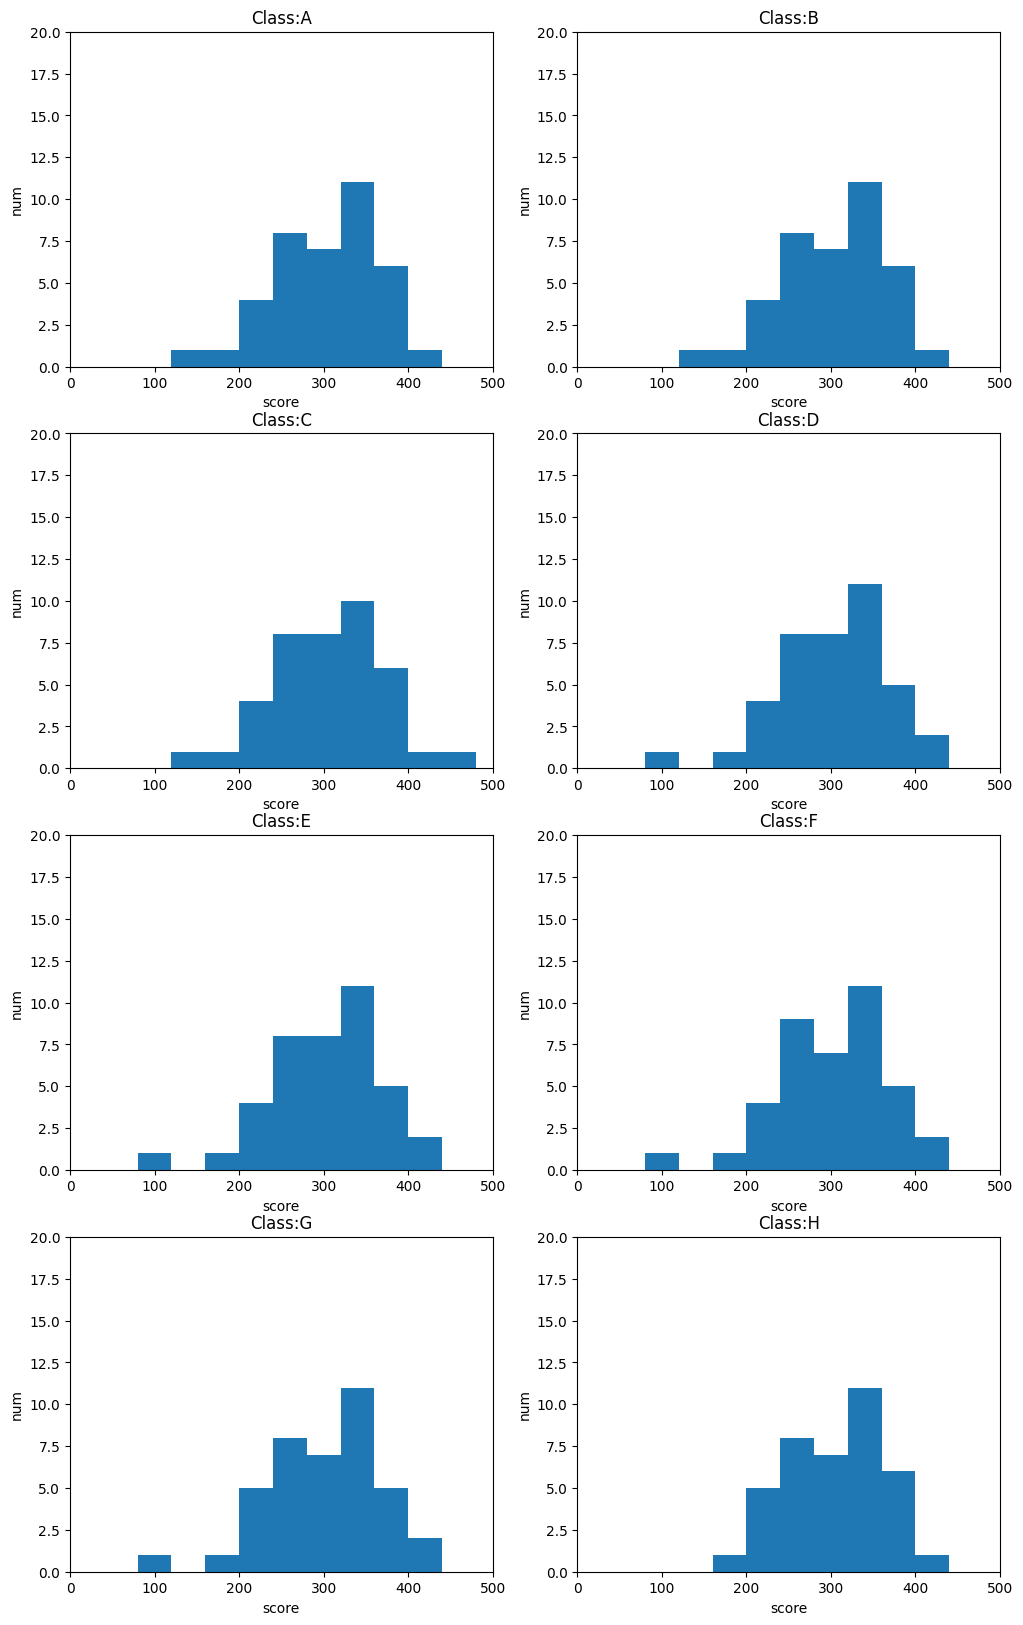

In [94]:
fig = plt.figure(figsize=(12, 20))
for i, c in enumerate(C):
    cls_df = s_df[s_df['init_assigned_class'] == c]
    ax = fig.add_subplot(4, 2, i+1, xlabel='score', ylabel='num', xlim=(0, 500), ylim=(0, 20), title='Class:{:s}'.format(c))
    ax.hist(cls_df['score'], bins=range(0, 500, 40))

In [95]:
# 目的関数：初期クラス編成とできるだけ一致させる
prob += pulp.lpSum(x[s,c] * init_flag[s,c] for s,c in SC)

In [96]:
import pandas as pd
import pulp

s_df = pd.read_csv('students.csv')
s_pair_df = pd.read_csv('student_pairs.csv')

prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

# 生徒のリスト
S = s_df['student_id'].tolist()

# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# 生徒とクラスのペアのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# (1)各生徒は１つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum([x[s,c] for c in C]) == 1

# (2)各クラスの生徒の人数は39人以上、40人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40

# 男子生徒のリスト
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

# 学力を辞書表現に変換
score = {row.student_id:row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()

# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
for c in C:
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) >= (score_mean - 10) * pulp.lpSum([x[s,c] for s in S])
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_support]) <= 1

# 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない。
for s1, s2 in SS:
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

# 初期クラス編成を作成
s_df['score_rank'] = s_df['score'].rank(ascending=False, method='first')
class_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_df['init_assigned_class'] = s_df['score_rank'].map(lambda x:x % 8).map(class_dic)
init_flag = {(s,c): 0 for s in S for c in C}
for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

# 目的関数:初期クラス編成と最適化結果のクラス編成をできるだけ一致させる
prob += pulp.lpSum([x[s,c] * init_flag[s,c] for s,c in SC])

# 求解
status = prob.solve()
print('Status:', pulp.LpStatus[status])

# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value()==1]

for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/isobekosuke/home/operations_research/venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/b9/s3mpk10s0s1bl06d5p5990h80000gn/T/2d3f67a3fcb545f28fc042d284813764-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/b9/s3mpk10s0s1bl06d5p5990h80000gn/T/2d3f67a3fcb545f28fc042d284813764-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 21298 RHS
At line 21705 BOUNDS
At line 24250 ENDATA
Problem MODEL has 406 rows, 2544 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298 - 0.01 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial st

In [97]:
# 検証用のデータフレームの用意
result_df2 = s_df.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {}
for s in S:
    S2C[s] = [c for c in C if x[s,c].value()==1][0]

# 生徒データに各生徒がどのクラスに割り当てられたかの情報を結合
result_df2['assigned_class'] = result_df2['student_id'].map(S2C)
result_df2.head(5)

student_id  gender  leader_flag  support_flag  score  score_rank  \
0           1       0            0             0    335       109.0   
1           2       1            0             0    379        38.0   
2           3       0            0             0    350        79.0   
3           4       0            0             0    301       172.0   
4           5       1            0             0    317       147.0   

  init_assigned_class assigned_class  
0                   F              F  
1                   G              A  
2                   H              H  
3                   E              E  
4                   D              D

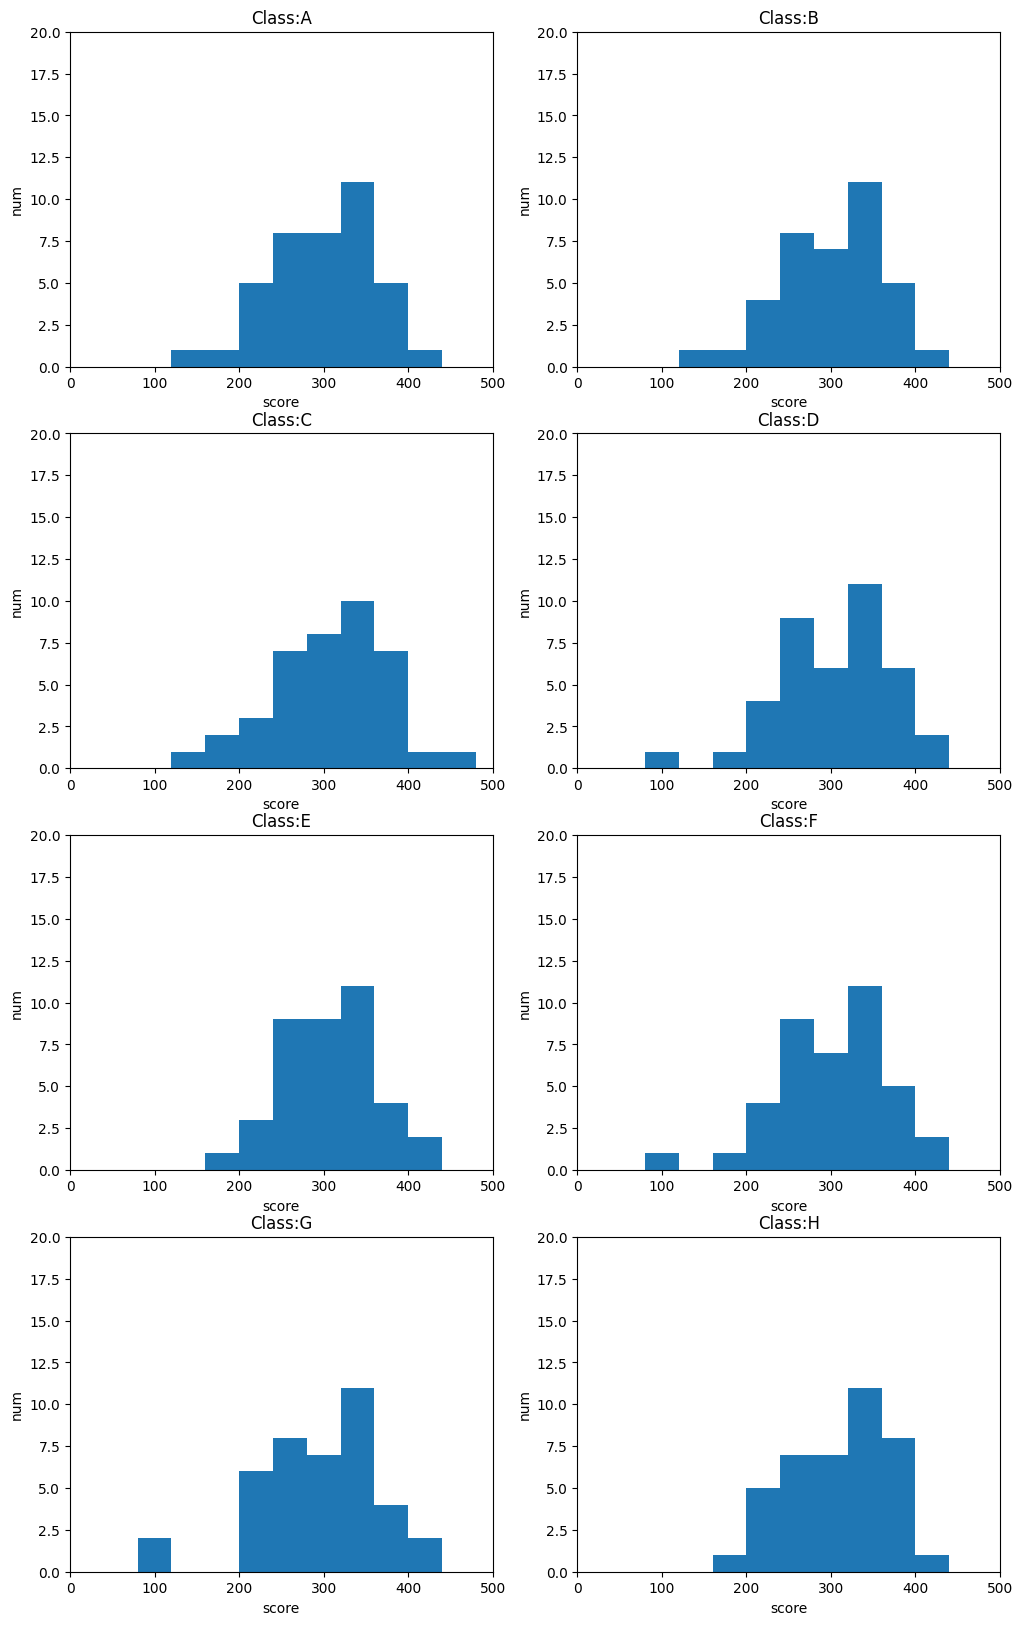

In [98]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_df = result_df2[result_df2['assigned_class']==c]
    ax = fig.add_subplot(4, 2, i+1, xlabel='score', ylabel='num', xlim=(0, 500), ylim=(0, 20), title='Class:{:s}'.format(c))
    ax.hist(cls_df['score'], bins=range(0,500,40))